### Imports

In [1]:
from tensorflow.keras.models import load_model
import pandas as pd
import pathlib
import tensorflow as tf
import os
import tensorflow.keras.applications     as     applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE
import seaborn as sns

In [2]:
sns.set_context('talk')
sns.set_style('dark')

In [3]:
%load_ext autoreload
%autoreload 2

In [191]:
%matplotlib inline
plt.ioff()

In [4]:
import sys
sys.path.append('../utilities/')
from utilities import (
    Timer,
    show_image,
    DreamImage,
    DeepDream,
    class_names,
    ProgressBar, 
    plot_confusion_matrix,
    load_model
)

### Setup

In [5]:
sns.set()

AUTOTUNE = tf.data.experimental.AUTOTUNE

width = height = 224
batch_size = 32

### Load the Model

In [6]:
model_name = 'vgg19-INet-down2-b'
base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')

# Remove dropout
model = Sequential()
for layer in base_model.layers[:-1]:
    if isinstance(layer, Dropout):
        pass
    else:
        model.add(layer)

### Load the Data in Special Form

In [7]:
# Load the list of file names in the form of data_dir/class_name/file_name.jpg
data_subdir = 'test'
data_dir = pathlib.Path('../dataset/images/') / pathlib.Path(data_subdir)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

dataset_size = len(list(list_ds))

In [8]:
# Function to get the label
#  Modification: get just the class name, not the vector
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

# Function to get the image
def decode_img(file_path):
    # Load the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize
    return tf.image.resize(img, [width, height])

# Preprocess
def preprocess_img(img, label, file_path):
    return applications.vgg19.preprocess_input(img), label, file_path

In [9]:
# Combine both processes
def process_path(file_path):
    return decode_img(file_path), get_label(file_path), file_path

In [10]:
def embed_image(img_batch, label_batch, file_path_batch):
    return model(img_batch), label_batch, file_path_batch

In [11]:
# Create the dataset
ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
ds = ds.map(preprocess_img)
ds = ds.batch(batch_size).prefetch(buffer_size = AUTOTUNE)
ds = ds.map(embed_image)
ds = ds.cache()

### Compute Embedding on the Dataset

Commented out because this is slow; only do once

In [12]:
# bar = ProgressBar(dataset_size // batch_size + 1)

# class_batches     = []
# label_batches     = []
# file_path_batches = []
# bar.start()
# iterations = 0
# for class_batch, label_batch, file_path_batch in ds:
#     class_batches.append(class_batch)
#     label_batches.append(label_batch)
#     file_path_batches.append(file_path_batch)
#     iterations+=1
#     bar.update(iterations)

### Extract Embeddings into a Convenient Numpy Array

In [16]:
# Convert to a single array
def concat_batches(batch_list):
    batch_list = [tensor.numpy() for tensor in batch_list]
    return np.concatenate(batch_list)

embedding  = concat_batches(class_batches)
labels     = concat_batches(label_batches)
file_paths = concat_batches(file_path_batches)

df = pd.concat([pd.Series(labels, name = 'artist'), pd.Series(file_paths, name = 'file_path'), pd.DataFrame(embedding)], axis = 'columns')
df.to_csv(f'{model_name}-embedding.csv')

### Load the Data and compute the Embedding

In [6]:
model_name = 'vgg19-INet-down2-b'
df = pd.read_csv(f'{model_name}-embedding.csv', index_col=0)

meta_data_cols = ['artist', 'file_path']
meta_data = df[meta_data_cols]

data = df.drop(meta_data_cols, axis = 'columns')
print(f'{len(df)} samples, {data.shape[1]} neurons')

# Embarassingly, 2813 of the 4096 neurons have died and never activate
num_zeros_in_col = (data == 0).sum()
is_dead_col      = num_zeros_in_col == len(data)
print(f'{is_dead_col.sum()} of the neurons are dead')

# Let's drop the offending columns
data = data.drop(is_dead_col[is_dead_col].index.tolist(), axis = 'columns')
print(f'Summary of the percentage of the time each living neuron activates')
print((data != 0).mean().describe())

2941 samples, 4096 neurons
2813 of the neurons are dead
Summary of the percentage of the time each living neuron activates
count    1283.000000
mean        0.015131
std         0.059972
min         0.000340
25%         0.000680
50%         0.001700
75%         0.006800
max         0.550833
dtype: float64


In [7]:
pca = PCA(n_components=50, random_state = 42)

data_pcaed = pca.fit_transform(data)

tsne = TSNE(random_state = 42, n_jobs = 3, verbose=1)

data_tsned = tsne.fit_transform(data_pcaed)

embedding = pd.DataFrame(data_tsned)
embedding.rename({0 : 'x', 1 : 'y'}, axis = 'columns', inplace = True)

embedding = pd.concat([meta_data, embedding], axis = 'columns')
# embedding.to_csv('tsne-embedding.csv')

### Visualize

In [33]:
embedding = pd.read_csv('tsne-embedding.csv', index_col = 0)

In [106]:
# The interplay between tensorflows performed format (byte "strings") 
#  and numpy/pandas (regular strings) has led to some weird string values
#  which need to be corrected

embedding.artist    = embedding.artist.str.slice(2, -1)
embedding.file_path = embedding.file_path.str.slice(2, -1)

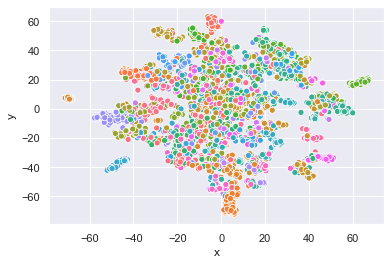

In [189]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'x', y = 'y', hue = 'artist', data = embedding, legend=False, ax = ax)
plt.show()

In [36]:
from math import floor, ceil

In [146]:
class Cell:
    
    def __init__(self, x_range, y_range):
        self.x_min, self.x_max = x_range
        self.y_min, self.y_max = y_range
        self.data  = None
        
    def contains(self, x, y):
        return (self.x_min <= x < self.x_max) and (self.y_min < y < self.y_max)
    
    def get_center(self):
        return (self.x_min + self.x_max) / 2, (self.y_min + self.y_max) / 2
    
    def __repr__(self):
        return(f'Cell from x = {self.x_min : .1f} to {self.x_max : .1f}'
               f' and y = {self.y_min : .1f} to {self.y_max : .1f}'     )

class Grid:
    def __init__(self,
                 x_min, x_max, 
                 y_min, y_max, 
                 x_regions, y_regions,
                 bbox = 0.1):
        # Record arguments
        # Pad the bounding box 
        self.x_min     = x_min - bbox
        self.x_max     = x_max + bbox
        self.y_min     = y_min - bbox
        self.y_max     = y_max + bbox
        self.x_regions = x_regions
        self.y_regions = y_regions
        
        # Set cutoffs for grid cells
        self.x_cutoffs = np.linspace(self.x_min, self.x_max, x_regions + 1)
        self.y_cutoffs = np.linspace(self.y_min, self.y_max, y_regions + 1)
        
        # Create pairs for grid cells
        x_cutoff_pairs = [(self.x_cutoffs[i-1], self.x_cutoffs[i]) for 
                          i in range(1, len(self.x_cutoffs))]
        y_cutoff_pairs = [(self.y_cutoffs[i-1], self.y_cutoffs[i]) for 
                          i in range(1, len(self.y_cutoffs))]
        
        # Create the cells
        self.cells     = [Cell(x_range, y_range) for x_range in x_cutoff_pairs
                                                 for y_range in y_cutoff_pairs]        
    
    def __iter__(self):
        return iter(self.cells)

In [147]:
grid = Grid(embedding.x.min(), embedding.x.max(), embedding.y.min(), embedding.y.max(), 60, 60)

In [177]:
# Assign an artwork to each cell

# Finds the artworks in each cell
def get_rows_in_cell(cell, df):
    return df[df.apply(lambda row : cell.contains(row.x, row.y), axis = 'columns')]

# Choose an artwork in each cell
def get_artwork_for_cell(df):
    # Pick the artist with the most representation in the cell
    #  break ties with a (deterministic via seeding) random choice
    # Return the appropriate row of the dataframe
    
    # Get artist counts, find the highest count, and select those artists
    artists     = df.artist.value_counts().sort_values(ascending = False)
    max_count   = artists.iloc[0]
    top_artists = artists[artists == max_count].index.values
    
    # Pick the top artist among ties, select their works
    top_artist  = np.random.choice(top_artists)
    works       = df[df.artist == top_artist].file_path
    
    # Pick the top work randomly, and return the row for that work
    work        = np.random.choice(works)
    row         = df[df.file_path == work]
    return row

In [185]:
bar = ProgressBar(3600)

In [35]:
# Compute an approximate image size to downsample and preserve memory
figsize  = (60, 60) # officially in inches

# Assume 72 pixels per inch (ppi)
ppi = 72

# Save some extra resolution just in case
cushion = 0.1

width  = int(figsize[0] * 72 / grid.x_regions * (1 + cushion))
height = int(figsize[1] * 72 / grid.y_regions * (1 + cushion))

In [ ]:
sns.set_style('white')
fig, ax = plt.subplots(figsize = figsize)
ax.set_axis_off()

ax.set_xlim(grid.x_min, grid.x_max)
ax.set_ylim(grid.y_min, grid.y_max)

In [ ]:
np.random.seed(42)
bar.start()
i = 0
for cell in grid:
    # Determine the artwork
    df          = get_rows_in_cell(cell, embedding)
    if len(df) == 0:
        cell.data = None
        continue
    artwork_row = get_artwork_for_cell(df)
    
    # Load the image
    artwork     = load_image(artwork_row.file_path.iloc[0], cast = tf.uint8).numpy()
    
    ax.imshow(artwork, extent = (cell.x_min, cell.x_max, cell.y_min, cell.y_max))
    i += 1
    bar.update(i)